
<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



# Image Processing


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_06-Image_Processing.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Imaging/CH3_06-Image_Processing.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load important packages

### Check Installed Packages

In [ ]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.3.22':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

### Import all relevant libraries

In [3]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:    
    %pylab --no-import-all notebook
    %gui qt
    
import warnings
warnings.filterwarnings('ignore')

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh

# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library


# The file format we use is pyUSID
import pyUSID as usid
import h5py as hf5

# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Using kinematic_scattering library version  0.6  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
pyUSID version:  0.0.9
pyTEM version:  0.2021.03.17


### Load an atomic resolution image:
As an example we will use **p1-3-hr3.dm3** in the ``example_data`` directory.

The image is of a sample of ZnO grown on graphene.

Cannot overwrite file. Using:  p1_3_hr3-5.hf5


<IPython.core.display.Javascript object>


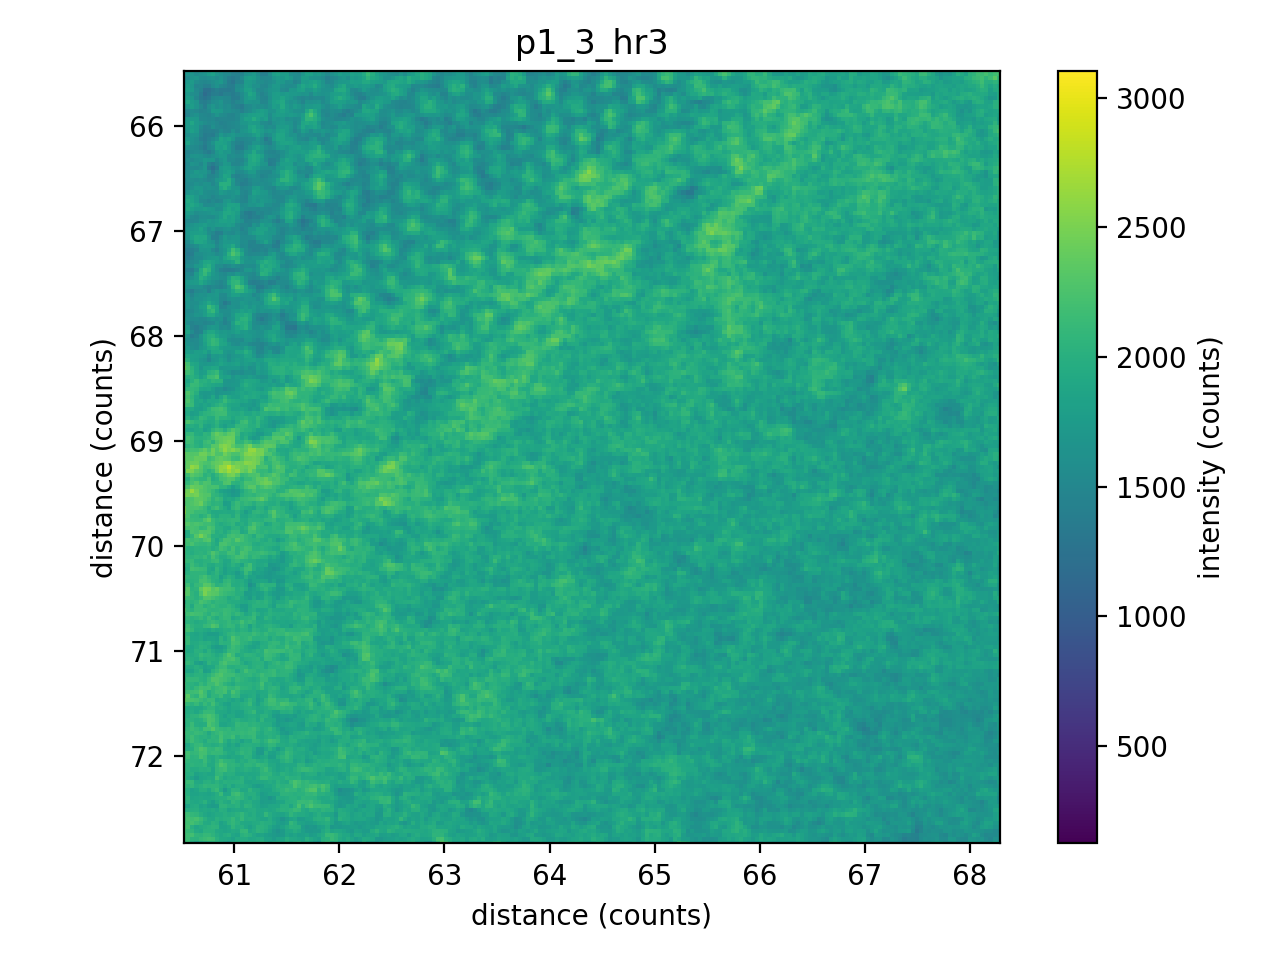

In [69]:
# ---- Input ------
load_example = True
# -----------------
## Close file if one is open
try:
    dataset.h5_dataset.file.close()
except:
    pass

if load_example:
    file_name = '../example_data/p1-3-hr3.dm3'
else:
    file_name = None
    
# Load file

dataset = ft.open_file(file_name)#os.path.join(current_directory,filename))
dataset.plot()

## Fourier Transform of Image

<IPython.core.display.Javascript object>


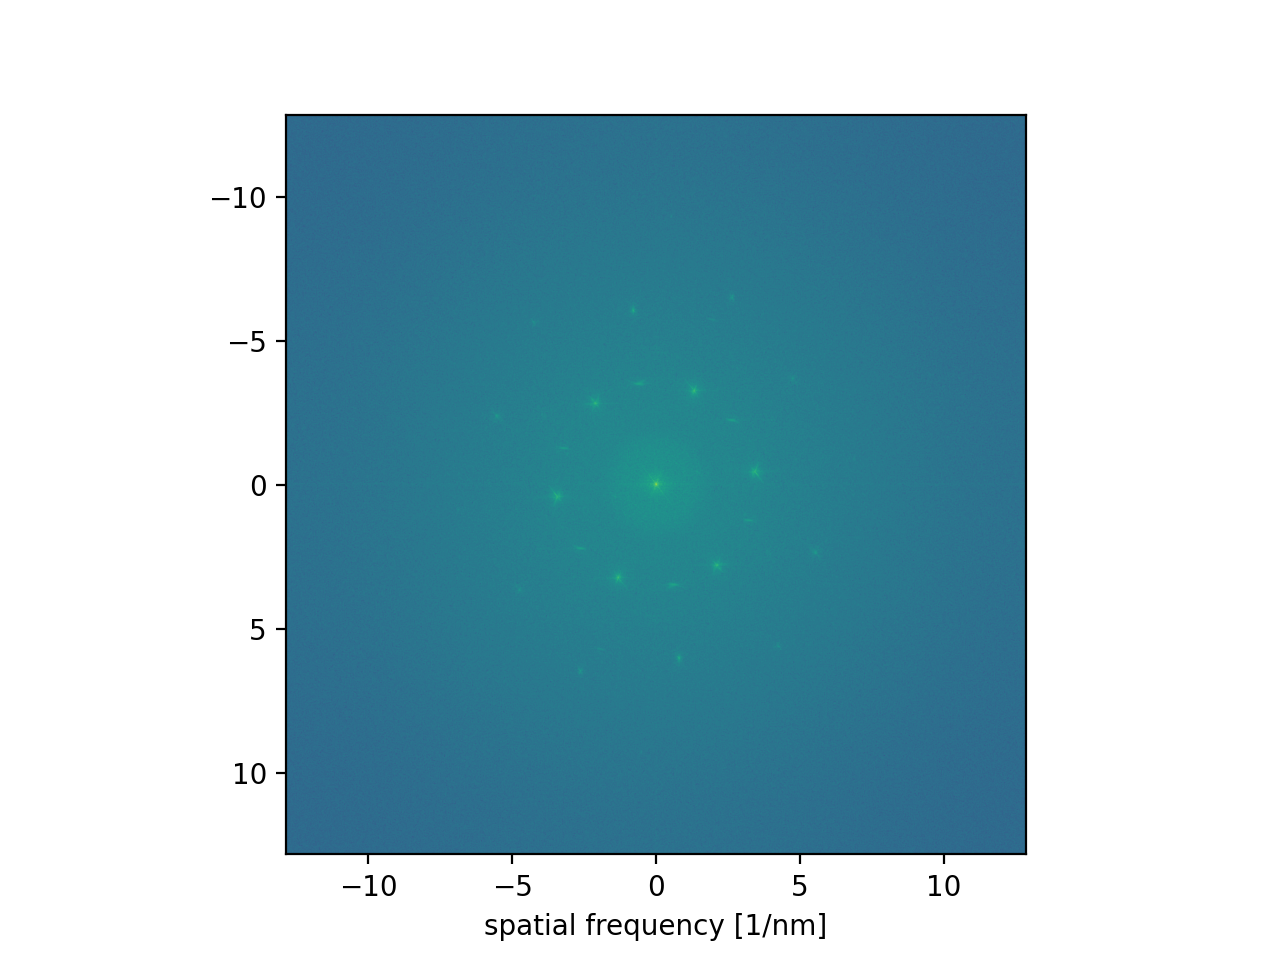

In [70]:

image = dataset-dataset.min()
fft_mag = np.abs((np.fft.fftshift(np.fft.fft2(image))))

## pixel_size in recipical space
rec_scale_x = 1/dataset.x[-1]  
rec_scale_y = 1/dataset.y[-1]

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * dataset.shape[0] /2.
rec_FOV_y = rec_scale_y * dataset.shape[1] /2.


## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)

fig = plt.figure()
plt.imshow(np.log2(1+fft_mag).T, extent=rec_extend, origin = 'upper'); 
plt.xlabel('spatial frequency [1/nm]');


## Shorter

<IPython.core.display.Javascript object>


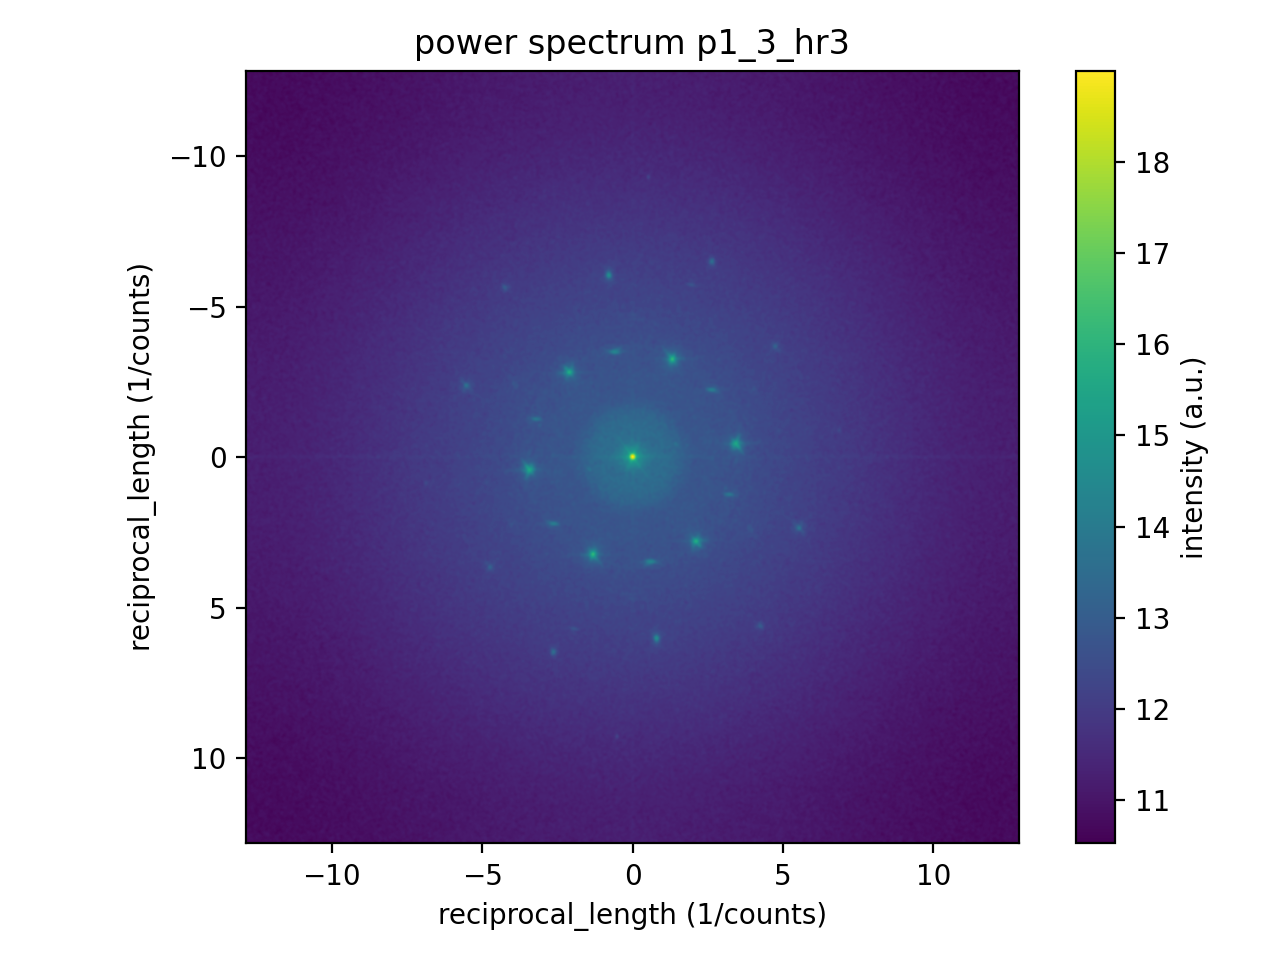

In [71]:
from pyTEMlib import image_tools as it
fft_mag = it.power_spectrum(dataset)
fft_mag.plot()

## More Contrast in Fourier Transform

Part of the low contrast is the high frequency noise in the diffractogram.
Smoothing with a Gaussian (3pixels wide) increases the contrast on logarithmic intensity scale.

Additionally, the minimum and maximum intensity can be used to increase the plotted contrast. For that we want to exclude 
- the center spot, which does not carry any spatial information and 
- the high frequencies which have always low intensities. 


0.5914055959172136 11.579141679482428 18.256675689336674
3.340085191885885 4.176874317680241


<IPython.core.display.Javascript object>


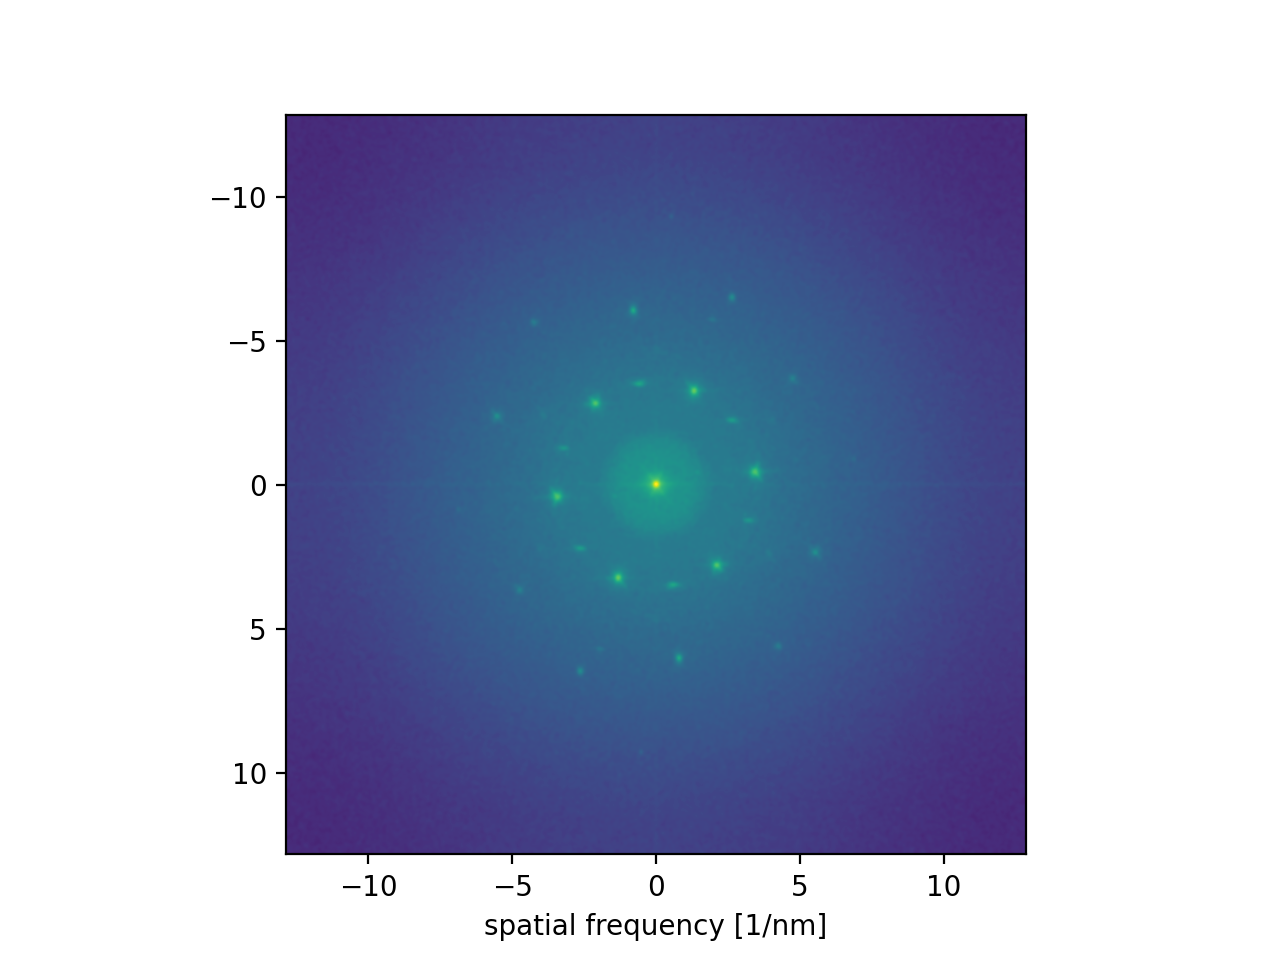

In [72]:
# We need some smoothing (here with a Gaussian)
smoothing = 3
fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)


#prepare mask for low and high frequencies
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x
x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

mask_spot = x**2+y**2 > 2**2 
mask = mask + mask_spot
mask_spot = x**2+y**2 < 10**2 
mask = mask + mask_spot

mask[np.where(mask==1)]=0 # just in case of overlapping disks

fft_mag3 = fft_mag2*mask
print(np.std(fft_mag2),np.mean(fft_mag2) ,np.max(fft_mag2) )
#print(np.std(fft_mag2[np.where(mask==2)]),np.mean(fft_mag2[np.where(mask==2)]) ,np.max(fft_mag2[np.where(mask==2)]))


minimum_intensity = np.log2(.1+fft_mag2)[np.where(mask==2)].min()*0.95
#minimum_intensity = np.mean(fft_mag3)-np.std(fft_mag3)
maximum_intensity = np.log2(.1+fft_mag2)[np.where(mask==2)].max()*1.05
#maximum_intensity =  np.mean(fft_mag3)+np.std(fft_mag3)*2

print(minimum_intensity,maximum_intensity)
fig = plt.figure()
plt.imshow(np.log2(.1+fft_mag2).T, extent=rec_extend, origin = 'upper',vmin=minimum_intensity, vmax=maximum_intensity)
plt.xlabel('spatial frequency [1/nm]');


## Spot Detection

This diffractogram is now good enough to detect the spots with a blob detector.

Found 23 reflections


<IPython.core.display.Javascript object>


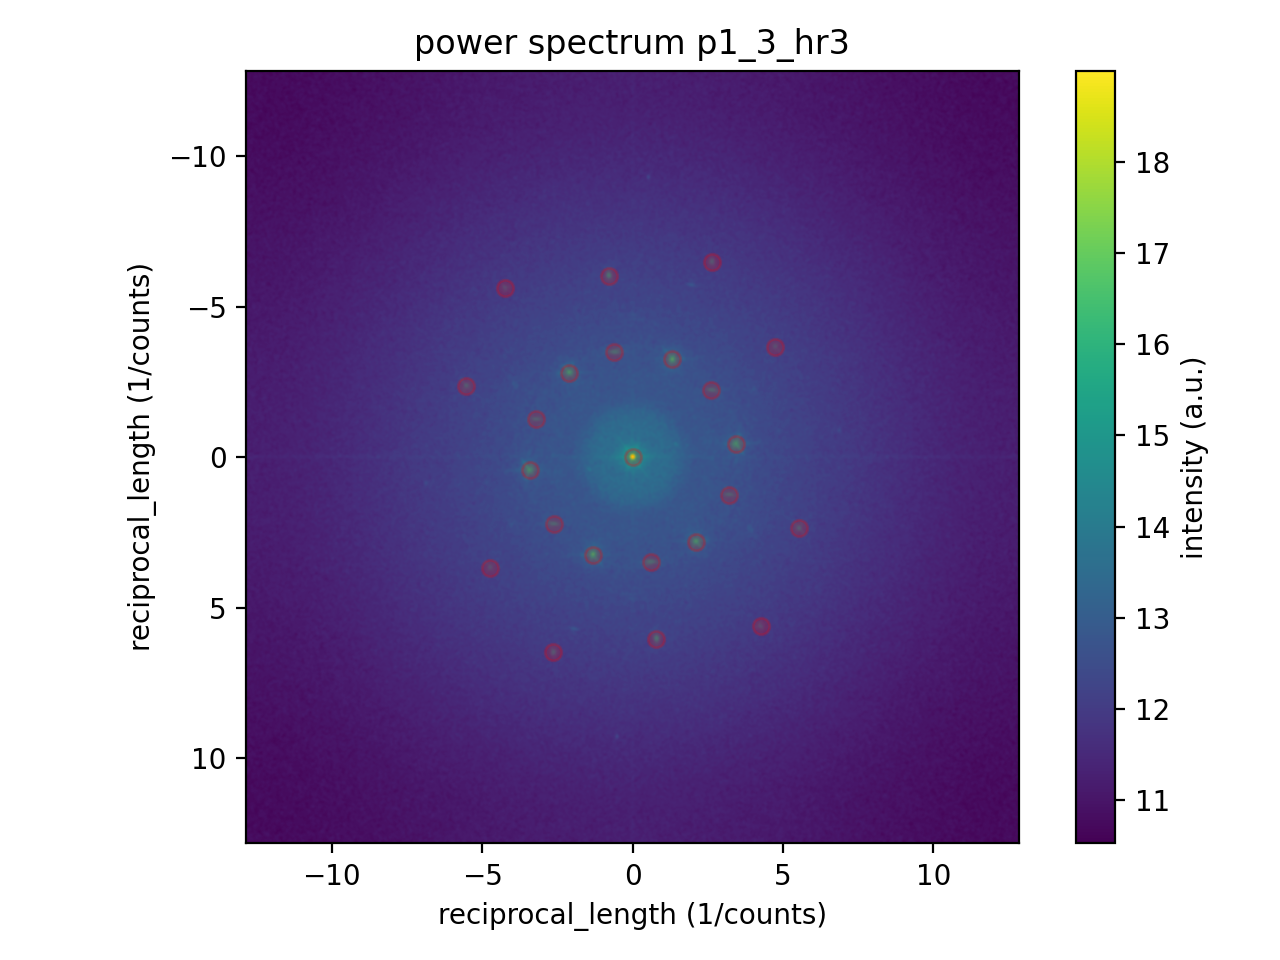

In [73]:
# ---- Input ---------
spot_threshold = .4
# --------------------

## Needed for conversion from pixel to Reciprocal space
rec_scale = np.array([rec_scale_x, rec_scale_y,1])
center = np.array([int(image.shape[0]/2), int(image.shape[1]/2),1] )

fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)
fft_mag2 = fft_mag2-fft_mag2.min()
#fft_mag2 = fft_mag2/fft_mag2.max()

# spot detection ( for future referece there is no symmetry assumed here)

spots_random =  (blob_log(fft_mag,  max_sigma= 5 , threshold=spot_threshold)-center)*rec_scale

print(f'Found {spots_random.shape[0]} reflections')
spots_random[:,2] = np.linalg.norm(spots_random[:,0:2], axis=1)
spots_index = np.argsort(spots_random[:,2])
spots = spots_random[spots_index]

## plot Fourier transform and found spots
fft_mag.plot()
plt.gca().scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.2, label='spots');
#plt.xlim(-0.2,0.2)
#plt.ylim(-0.2,0.2);

## Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image, the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-pass** area in the code below and notice the effects on the Fourier filtered image.



<IPython.core.display.Javascript object>


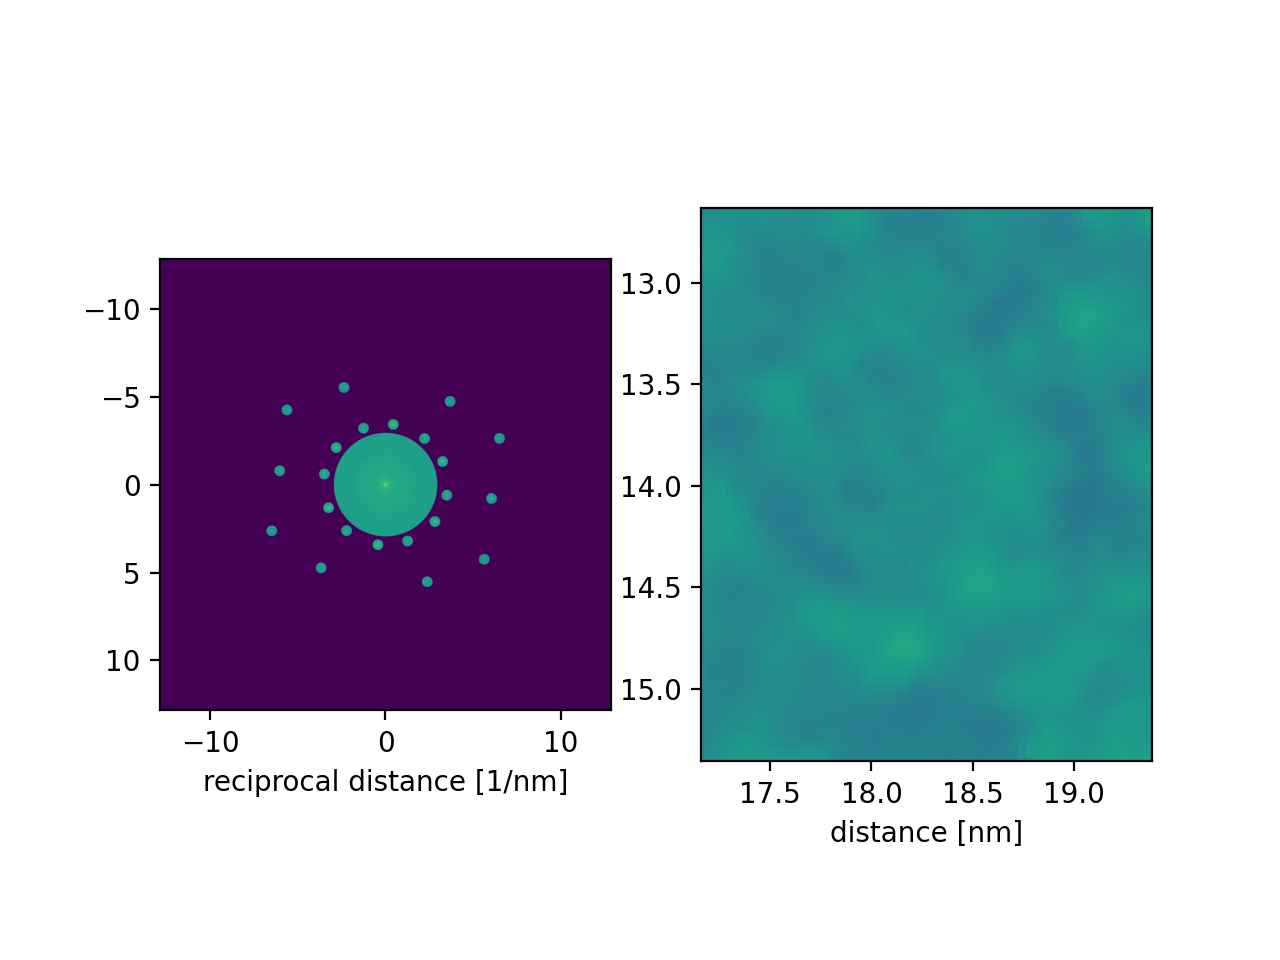

In [44]:
# Input 
reflection_radius = 0.3 # in 1/nm
low_pass = 1/.34 # in 1/nm diameter of mask for low pass filter
FOV_x = dataset.x[-1]
FOV_y = dataset.y[-1]


#prepare mask
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

# mask reflections
for spot in spots:
    mask_spot = (x-spot[0])**2+(y-spot[1])**2 < reflection_radius**2 # make a spot 
    mask = mask + mask_spot# add spot to mask
    
# mask zero region larger (low-pass filter = intensity variations)

mask_spot = x**2+y**2 < low_pass**2 
mask = mask + mask_spot

mask[np.where(mask>1)]=1 # just in case of overlapping disks

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(image))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered))

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


### Plot the image a bit bigger

<IPython.core.display.Javascript object>


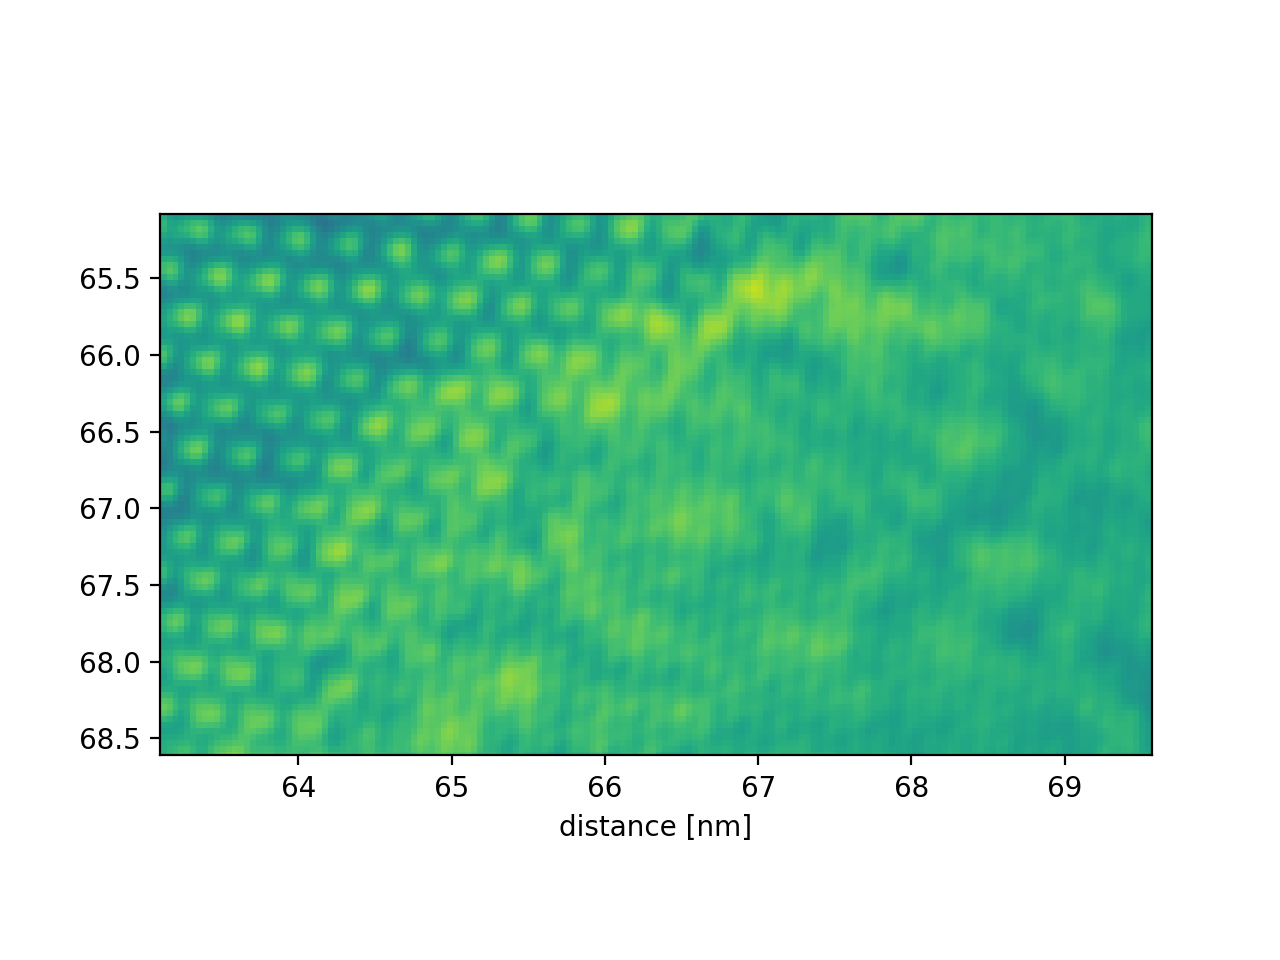

In [45]:
plt.figure()
plt.imshow(filtered.real, extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');

## Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


<IPython.core.display.Javascript object>


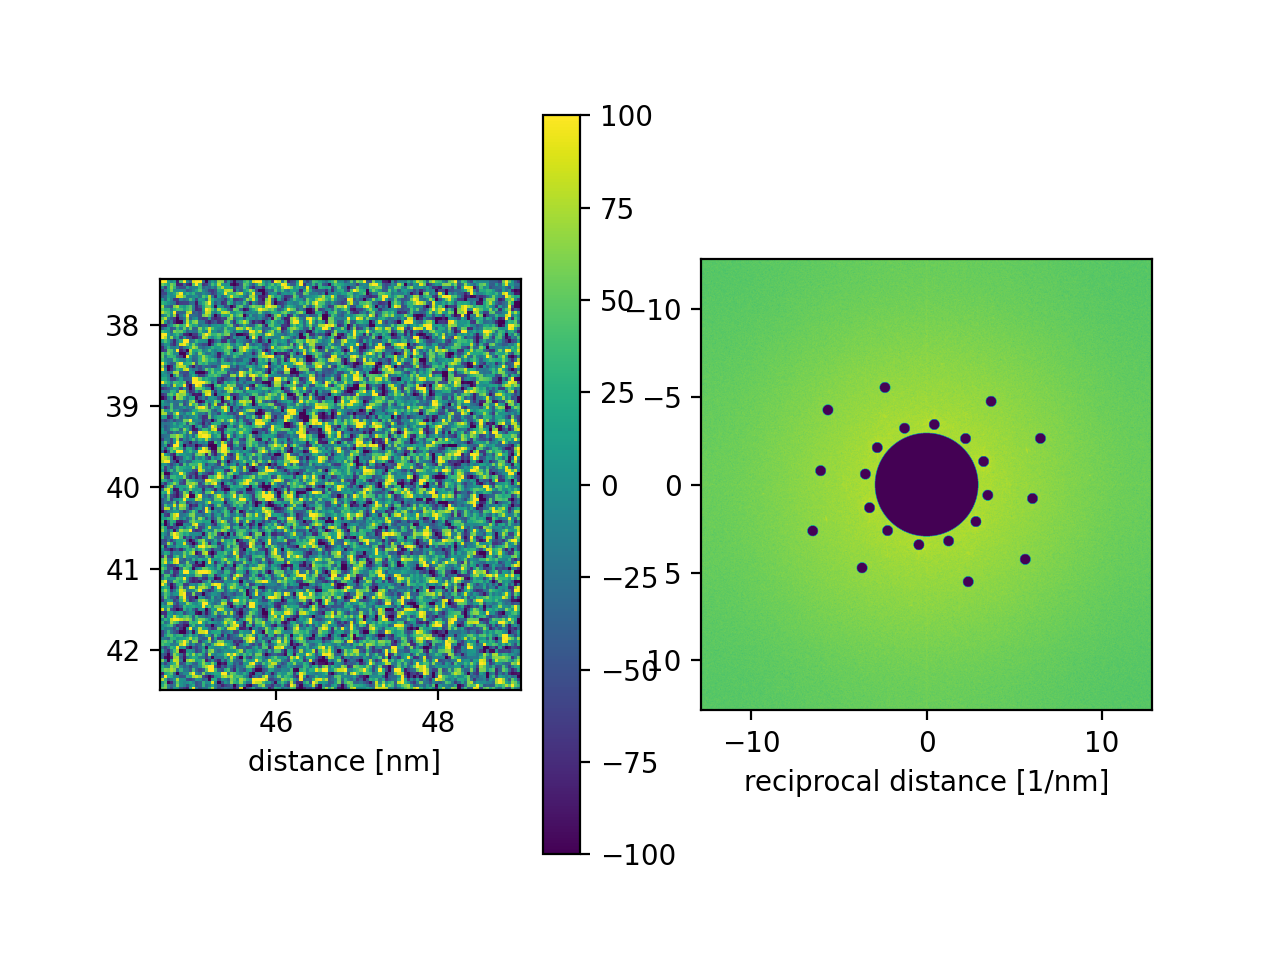

In [66]:
filtered = np.array(filtered)
plt.figure()
ax1 = plt.subplot(1,2,1)
im1 = ax1.imshow(image-filtered.real,extent=real_extent, origin = 'upper', vmin=-100, vmax=100)
plt.xlabel(' distance [nm]')
plt.colorbar(im1)
ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(image-filtered.real).T)
im2 = ax2.imshow(np.log(1+np.abs(fft_difference)).real.T,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

## Conclusion:

Fourier Transform is used to evaluate image quality and Fourier Filtering is used to eliminate high frequency noise.

If the computer is used to find the spots in the diffractogram, we do not have to select them ourselfs.
A carefull selection will,however, yield the same result.

## Navigation
- <font size = "3">  **Up Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>
- <font size = "3">  **Back: [Defocus Thickness Map](CH3_05-Defocus_Thickness.ipynb)** </font>
- <font size = "3">  **Next: [Image Analysis](CH3_07-Image_Analysis.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>
